In [2]:
# Import necessary libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from sklearn.feature_selection import mutual_info_regression

In [3]:
# Load data
df = pd.read_csv('data/preprocessed/main.csv')
df.head()

# Ensure 'Date' is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
# Dataset summary
print(df.info())
# print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420212 entries, 0 to 420211
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         420212 non-null  int64         
 1   Date          420212 non-null  datetime64[ns]
 2   Temperature   420212 non-null  float64       
 3   Fuel_Price    420212 non-null  float64       
 4   MarkDown1     150181 non-null  float64       
 5   MarkDown2     110904 non-null  float64       
 6   MarkDown3     136651 non-null  float64       
 7   MarkDown4     134518 non-null  float64       
 8   MarkDown5     150929 non-null  float64       
 9   CPI           420212 non-null  float64       
 10  Unemployment  420212 non-null  float64       
 11  IsHoliday     420212 non-null  bool          
 12  Dept          420212 non-null  int64         
 13  Weekly_Sales  420212 non-null  float64       
 14  Store_Type    420212 non-null  object        
 15  Store_Size    420

### Basic stats

In [5]:
print(df.describe())
# Some columns like "Store" might not be relevant here

               Store                           Date    Temperature  \
count  420212.000000                         420212  420212.000000   
mean       22.195611  2011-06-18 07:35:12.682170112      60.090599   
min         1.000000            2010-02-05 00:00:00      -2.060000   
25%        11.000000            2010-10-08 00:00:00      46.680000   
50%        22.000000            2011-06-17 00:00:00      62.090000   
75%        33.000000            2012-02-24 00:00:00      74.280000   
max        45.000000            2012-10-26 00:00:00     100.140000   
std        12.787236                            NaN      18.447857   

          Fuel_Price      MarkDown1      MarkDown2      MarkDown3  \
count  420212.000000  150181.000000  110904.000000  136651.000000   
mean        3.360890    7247.821269    3330.146158    1441.736203   
min         2.472000       0.270000    -265.760000     -29.100000   
25%         2.933000    2240.270000      41.600000       5.100000   
50%         3.452000    

In [6]:
# Select only numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate basic statistical values
basic_stats = pd.DataFrame({
    'Mean': df[numerical_columns].mean(),
    'Median': df[numerical_columns].median(),
    'Standard Deviation': df[numerical_columns].std(),
    'First Quartile (Q1)': df[numerical_columns].quantile(0.25),
    'Third Quartile (Q3)': df[numerical_columns].quantile(0.75)
})

print(basic_stats)


                       Mean         Median  Standard Deviation  \
Store             22.195611      22.000000           12.787236   
Temperature       60.090599      62.090000           18.447857   
Fuel_Price         3.360890       3.452000            0.458519   
MarkDown1       7247.821269    5347.450000         8293.028741   
MarkDown2       3330.146158     192.000000         9460.395025   
MarkDown3       1441.736203      24.600000         9631.968459   
MarkDown4       3384.782267    1481.310000         6295.136952   
MarkDown5       4629.531870    3359.450000         5960.171711   
CPI              171.212496     182.350989           39.162445   
Unemployment       7.960000       7.866000            1.863879   
Dept              44.241309      37.000000           30.508819   
Weekly_Sales   16033.114591    7661.700000        22729.492116   
Store_Size    136749.732787  140167.000000        60993.084568   

              First Quartile (Q1)  Third Quartile (Q3)  
Store             

### Histograms of Each Numerical Column

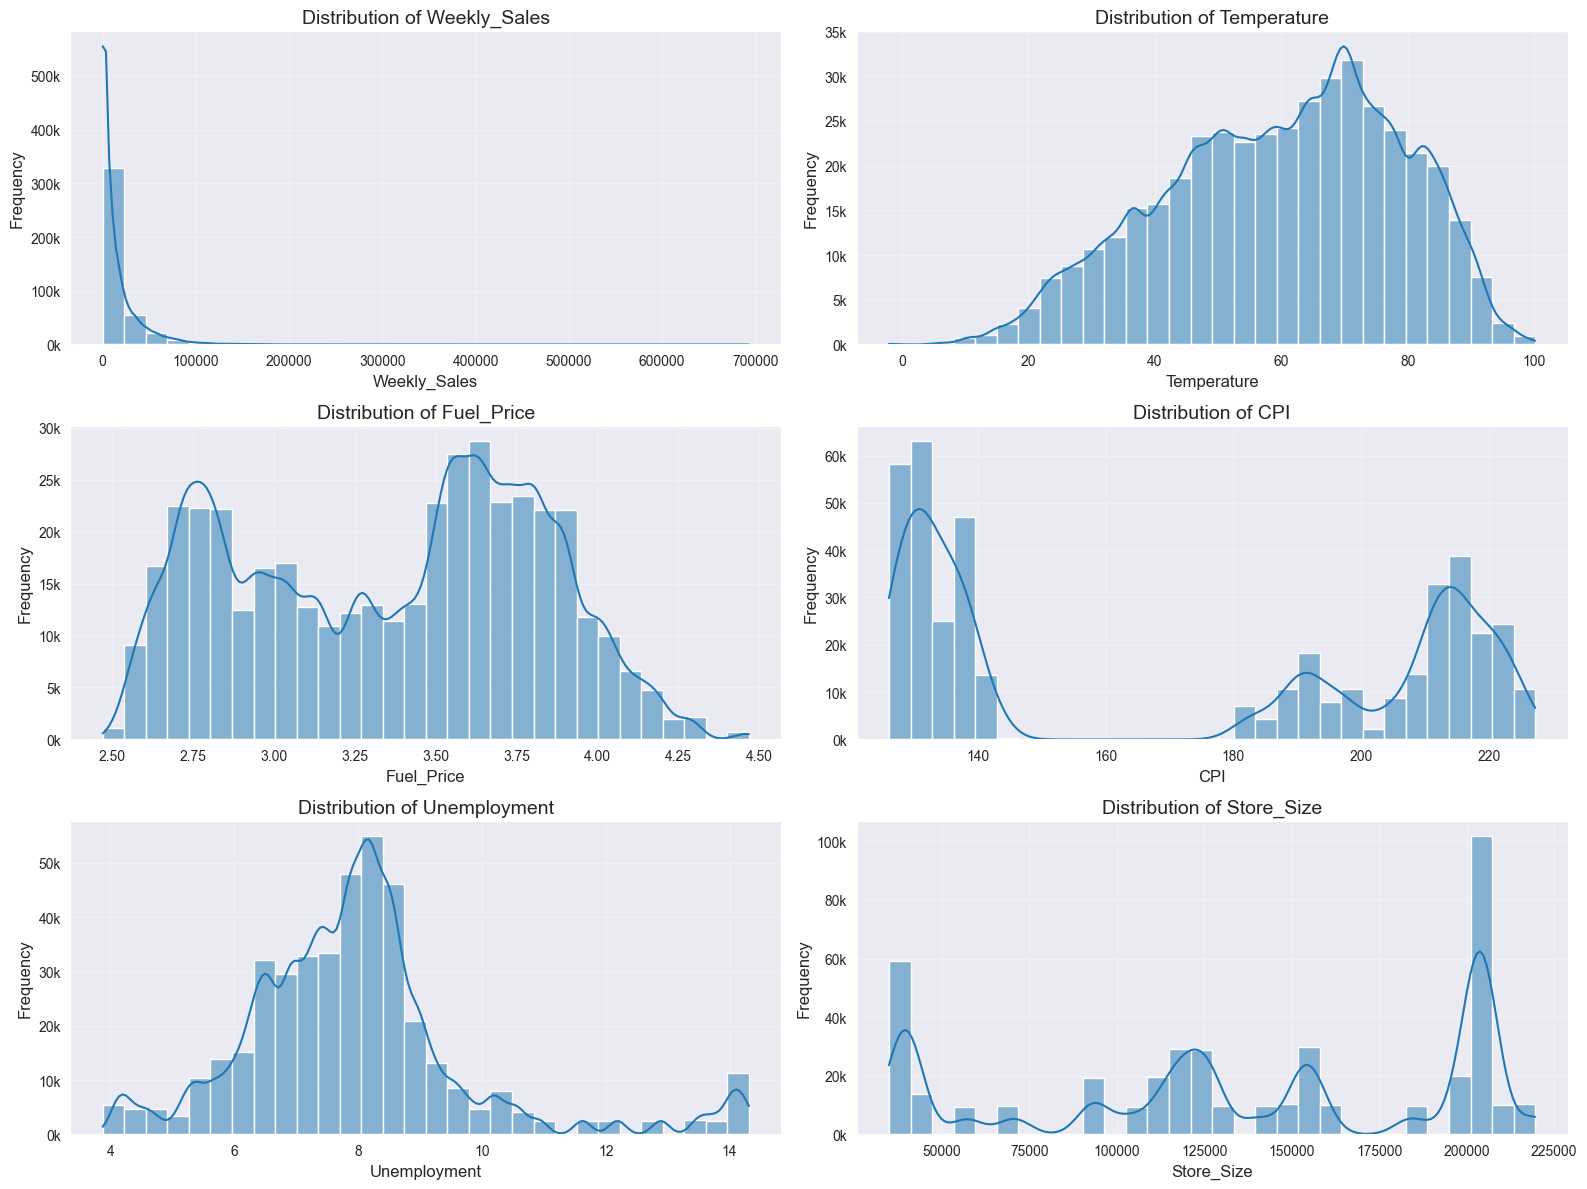

In [7]:
numerical_columns = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Store_Size']

# Set up the figure
plt.figure(figsize=(16, 12))

# Loop through each column and create a subplot
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 2, i)  # Adjust rows and columns as needed
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1000)}k'))
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


### 1.1 Weekly Sales Over Time/Impact of Holidays on Sales

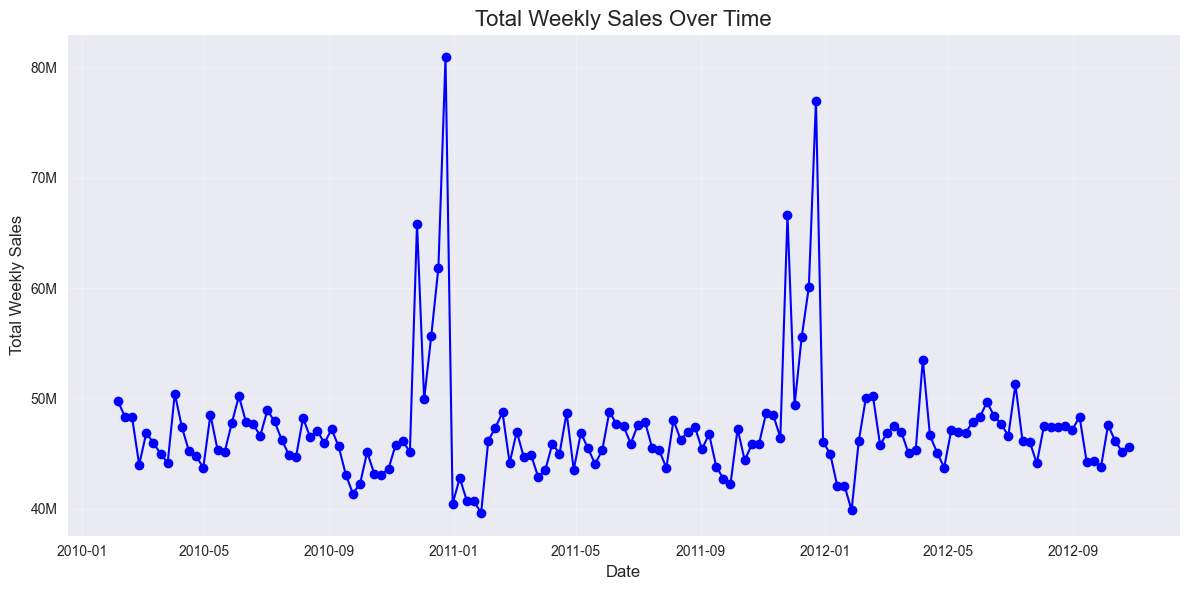

In [8]:
# Group by date and sum up weekly sales
weekly_sales_over_time = df.groupby('Date')['Weekly_Sales'].sum()

def format_yaxis(value, _):
    return f"{int(value/1000000)}M"

# Plot the sales over time
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales_over_time.index, weekly_sales_over_time, marker='o', linestyle='-', color='b')
plt.title('Total Weekly Sales Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Weekly Sales', fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_yaxis))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### 1.2 Average monthly sales across years

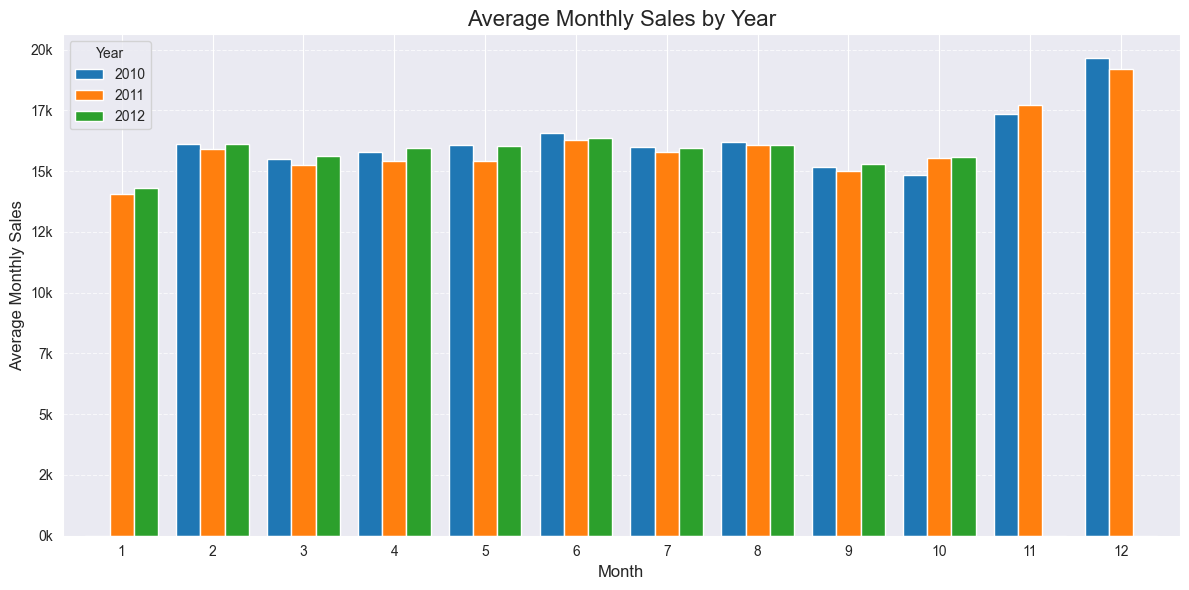

In [9]:
# Extract year and month from the 'Date' column
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Group data by Year and Month and calculate average sales
monthly_sales = df.groupby(['Year', 'Month'])['Weekly_Sales'].mean().reset_index()
pivot_data = monthly_sales.pivot(index='Month', columns='Year', values='Weekly_Sales')

# Plot grouped bar chart
pivot_data.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title('Average Monthly Sales by Year', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Monthly Sales', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Year', loc='upper left', fontsize=10)

# Format y-axis
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1000)}k'))

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### 2 Holidays Vs Non-holidays Sales

C:\Users\ishar\AppData\Local\Temp\ipykernel_205420\3810045479.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=holiday_sales.values, x=holiday_sales.index, ax=axes[0], palette='Blues_d')
C:\Users\ishar\AppData\Local\Temp\ipykernel_205420\3810045479.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=holiday_counts.values, x=holiday_counts.index, ax=axes[1], palette='Reds_d')


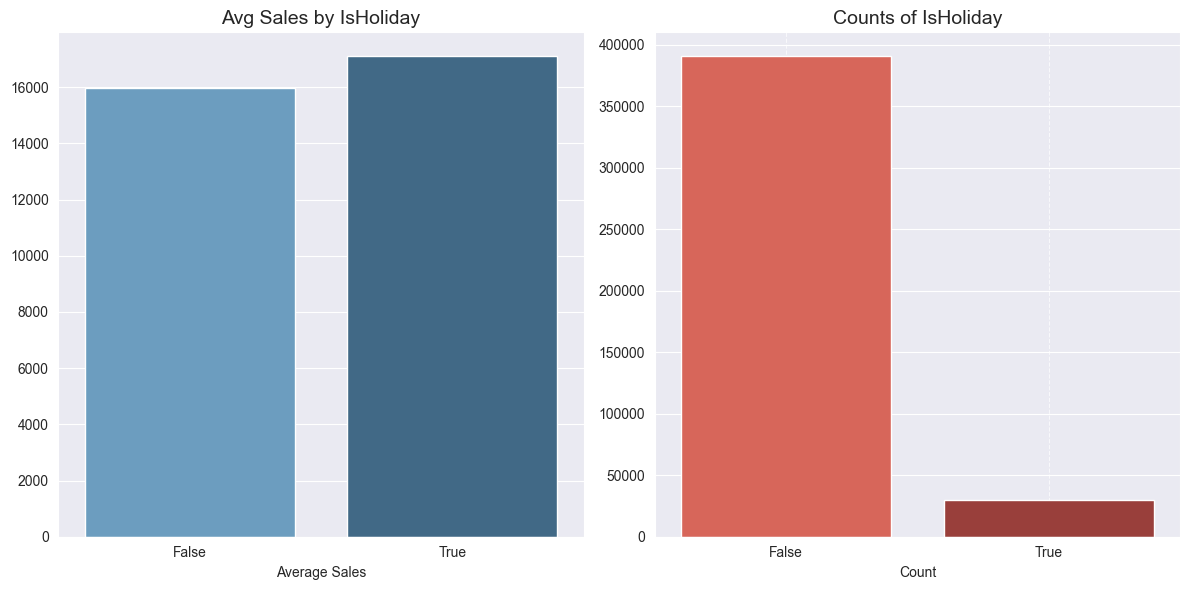

In [10]:
# Aggregate data
holiday_sales = df.groupby('IsHoliday')['Weekly_Sales'].mean()
holiday_counts = df['IsHoliday'].value_counts()

# Create a subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# Plot 1: Average sales during holidays vs non-holidays
sns.barplot(y=holiday_sales.values, x=holiday_sales.index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Avg Sales by IsHoliday', fontsize=14)
axes[0].set_xlabel('Average Sales')
axes[0].set_ylabel('')
# axes[0].grid(axis='x', linestyle='--', alpha=0.7)

# Plot 2: Counts of holidays and non-holidays
sns.barplot(y=holiday_counts.values, x=holiday_counts.index, ax=axes[1], palette='Reds_d')
axes[1].set_title('Counts of IsHoliday', fontsize=14)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### 3 Sales by Store

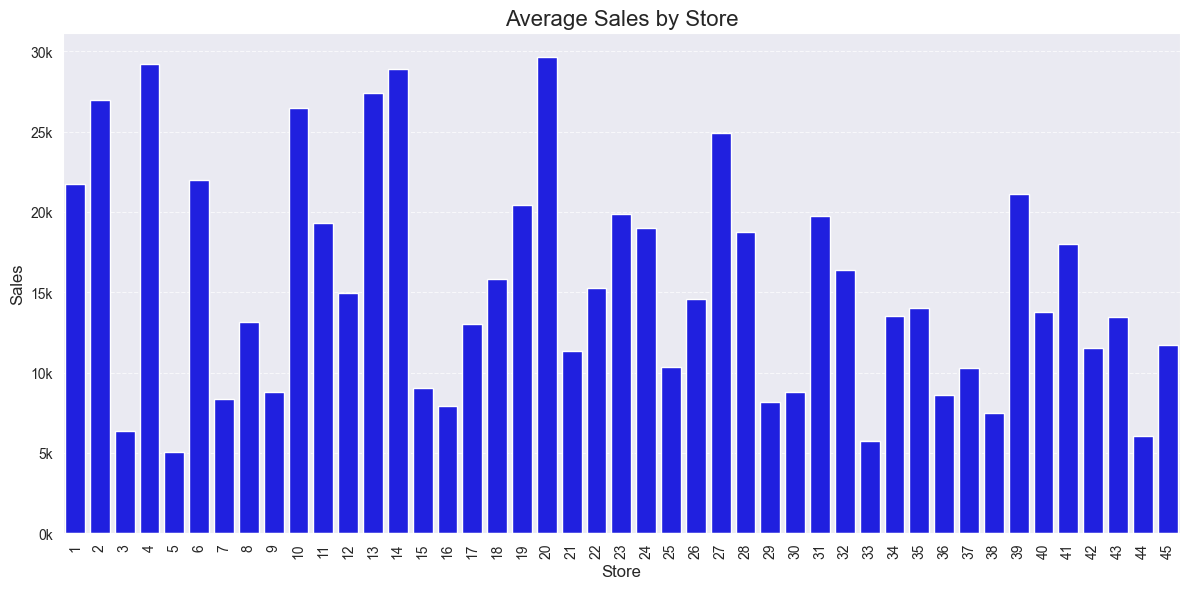

In [11]:
# Group by Store and calculate average sales
store_sales = df.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=store_sales.index, y=store_sales.values, color='blue')
plt.title('Average Sales by Store', fontsize=16)
plt.xlabel('Store', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1000)}k'))
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [12]:
# Count the number of records by Store
store_record_counts = df['Store'].value_counts()
print(store_record_counts)


Store
13    10457
4     10267
10    10260
1     10226
2     10214
24    10210
34    10206
27    10196
6     10189
20    10173
32    10170
19    10114
31    10101
28    10099
41    10057
11    10033
23    10018
14    10005
40    10003
8      9883
15     9854
26     9844
39     9839
17     9812
18     9805
25     9768
7      9738
12     9665
22     9646
45     9610
21     9544
29     9424
16     9403
35     9402
3      9026
5      8978
9      8834
38     7351
37     7198
44     7142
30     7139
42     6907
43     6727
33     6478
36     6197
Name: count, dtype: int64


### 4. Sales by Department

##### Average Sales by Department

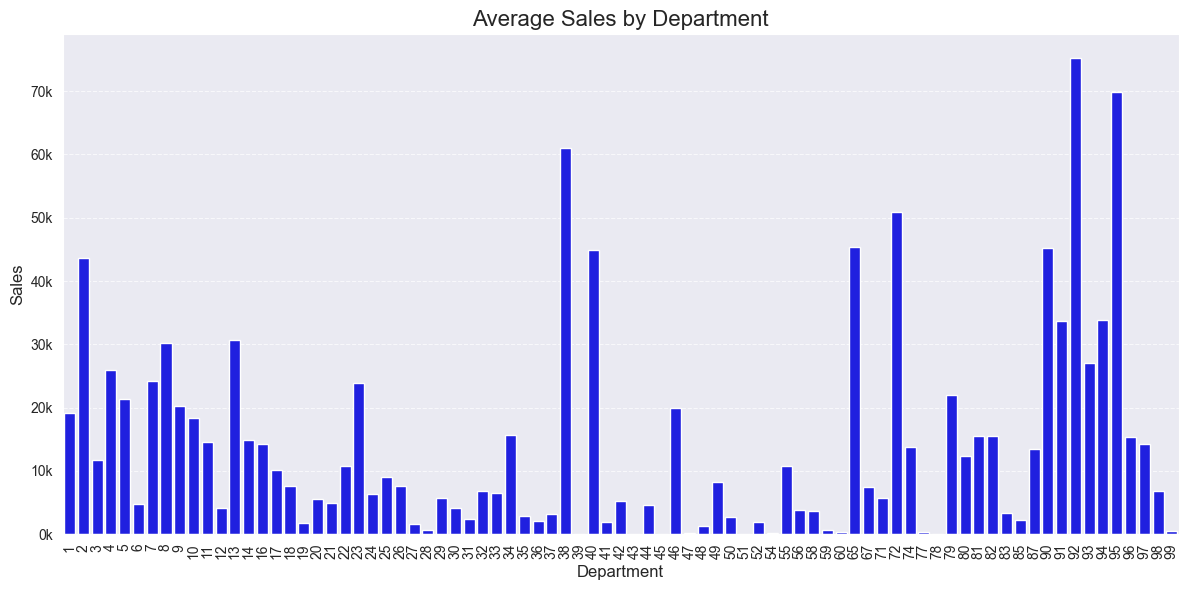

In [13]:
# Group by Dept and calculate average sales
store_sales = df.groupby('Dept')['Weekly_Sales'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=store_sales.index, y=store_sales.values, color='blue')
plt.title('Average Sales by Department', fontsize=16)
plt.xlabel('Department', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1000)}k'))
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

##### Sales overtime by highest 5 and lowest 5 department

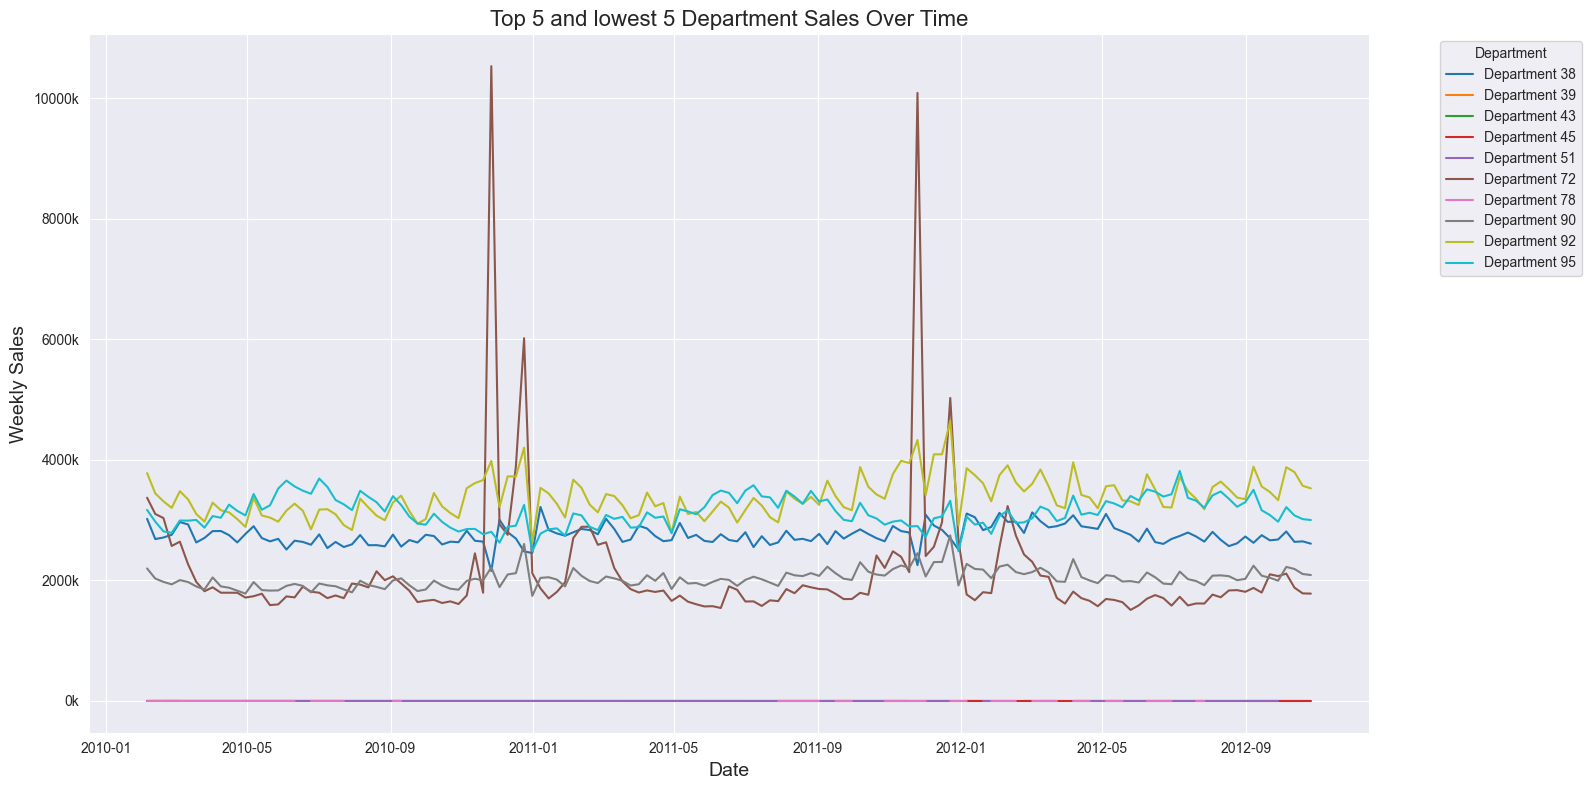

In [14]:
# Aggregate sales data for each department over time
department_sales = df.groupby(['Date', 'Dept'])['Weekly_Sales'].sum().unstack()

# Calculate average weekly sales for each department
average_sales = department_sales.mean().sort_values(ascending=False)

# Select the top 5 and bottom 5 departments with the highest and lowest average sales
top_5_departments = average_sales.head(5).index
bottom_5_departments = average_sales.tail(5).index
selected_departments = top_5_departments.union(bottom_5_departments)
filtered_sales = department_sales[selected_departments]

# Plot the data
plt.figure(figsize=(16, 8))
for department in filtered_sales.columns:
    plt.plot(filtered_sales.index, filtered_sales[department], label=f'Department {department}')

plt.title('Top 5 and lowest 5 Department Sales Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1000)}k'))
plt.legend(title='Department', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

##### Average Department Sales each year

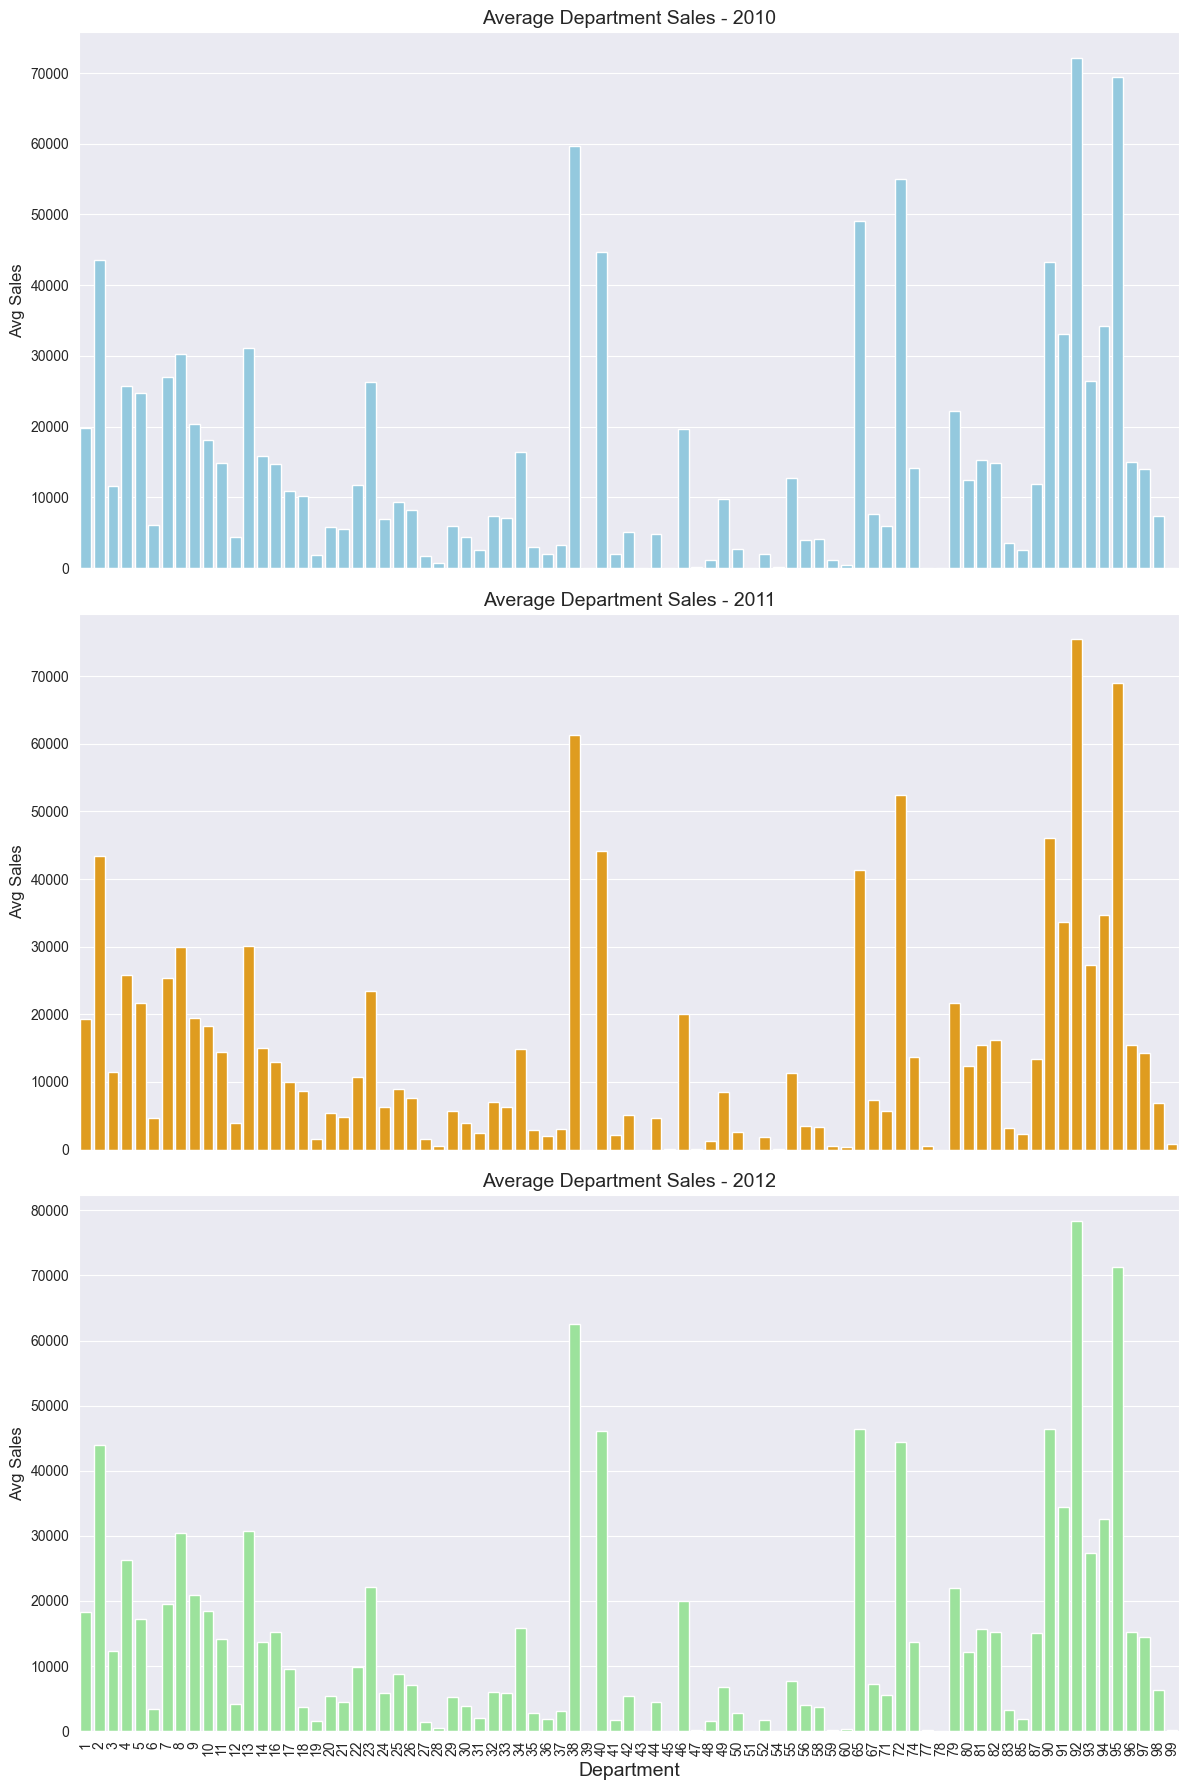

In [15]:
# Group by Department and Year to calculate average sales
avg_sales_per_year = df.groupby(['Year', 'Dept'])['Weekly_Sales'].mean().reset_index()

fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

years = sorted(df['Year'].unique())
colors = ['skyblue', 'orange', 'lightgreen']

for i, year in enumerate(years):
    yearly_data = avg_sales_per_year[avg_sales_per_year['Year'] == year]
    
    # Plot the bar chart
    sns.barplot(
        x='Dept', y='Weekly_Sales', data=yearly_data,
        ax=axes[i], color=colors[i]
    )
    axes[i].set_title(f'Average Department Sales - {year}', fontsize=14)
    axes[i].set_ylabel('Avg Sales', fontsize=12)
    axes[i].tick_params(axis='x', rotation=90)


plt.xlabel('Department', fontsize=14)
plt.tight_layout()
plt.show()

### 5. Store size vs Sales

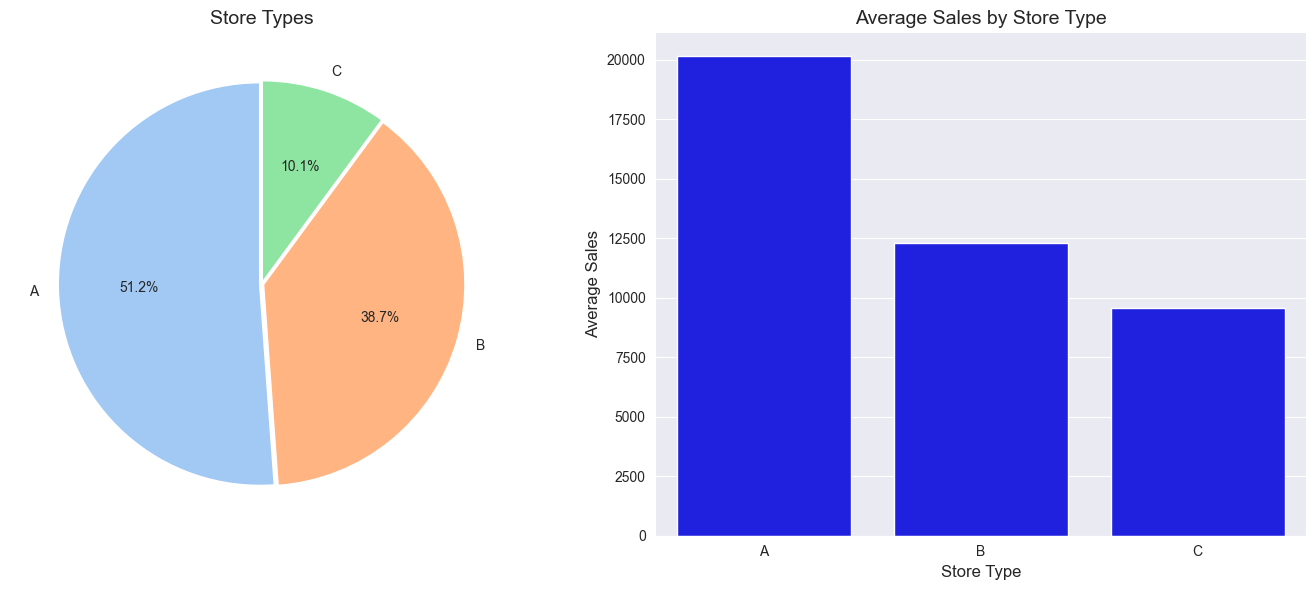

In [16]:
# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Create a grid with 1 row and 2 columns

# Plot 1: Pie Chart for Percentage of Each Store Type
df['Store_Type'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    startangle=90, 
    ax=axes[0],
    colors=sns.color_palette('pastel'),
    explode=[0.01, 0.01, 0.01] 
)
axes[0].set_title('Store Types', fontsize=14)
axes[0].set_ylabel('')

# Plot 2: Bar Chart for Average Sales by Store Type
avg_sales_per_store_type = df.groupby('Store_Type')['Weekly_Sales'].mean()
sns.barplot(
    x=avg_sales_per_store_type.index, 
    y=avg_sales_per_store_type.values, 
    ax=axes[1], 
    color='blue'
)
axes[1].set_title('Average Sales by Store Type', fontsize=14)
axes[1].set_xlabel('Store Type', fontsize=12)
axes[1].set_ylabel('Average Sales', fontsize=12)
axes[1].tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.show()

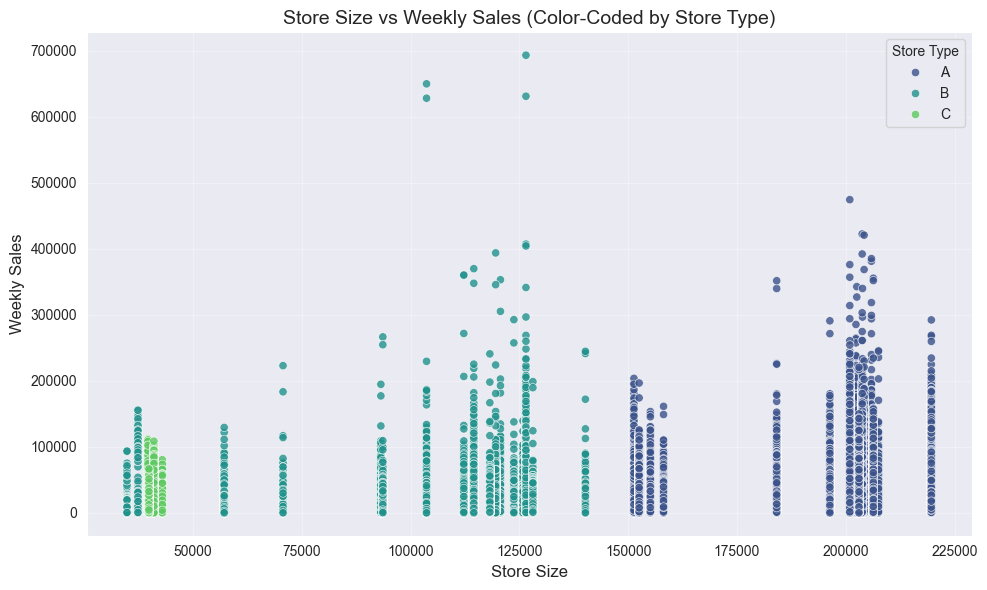

In [17]:
# Scatter plot: Store Size vs. Sales, color-coded by Store_Type
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='Store_Size',
    y='Weekly_Sales',
    hue='Store_Type',  # Color-coded by Store_Type
    palette='viridis',
    alpha=0.8
)

# Show the plot
plt.title('Store Size vs Weekly Sales (Color-Coded by Store Type)', fontsize=14)
plt.xlabel('Store Size', fontsize=12)
plt.ylabel('Weekly Sales', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(title='Store Type')
plt.tight_layout()
plt.show()

### 5. Relationship between external factors and Weekly_sales

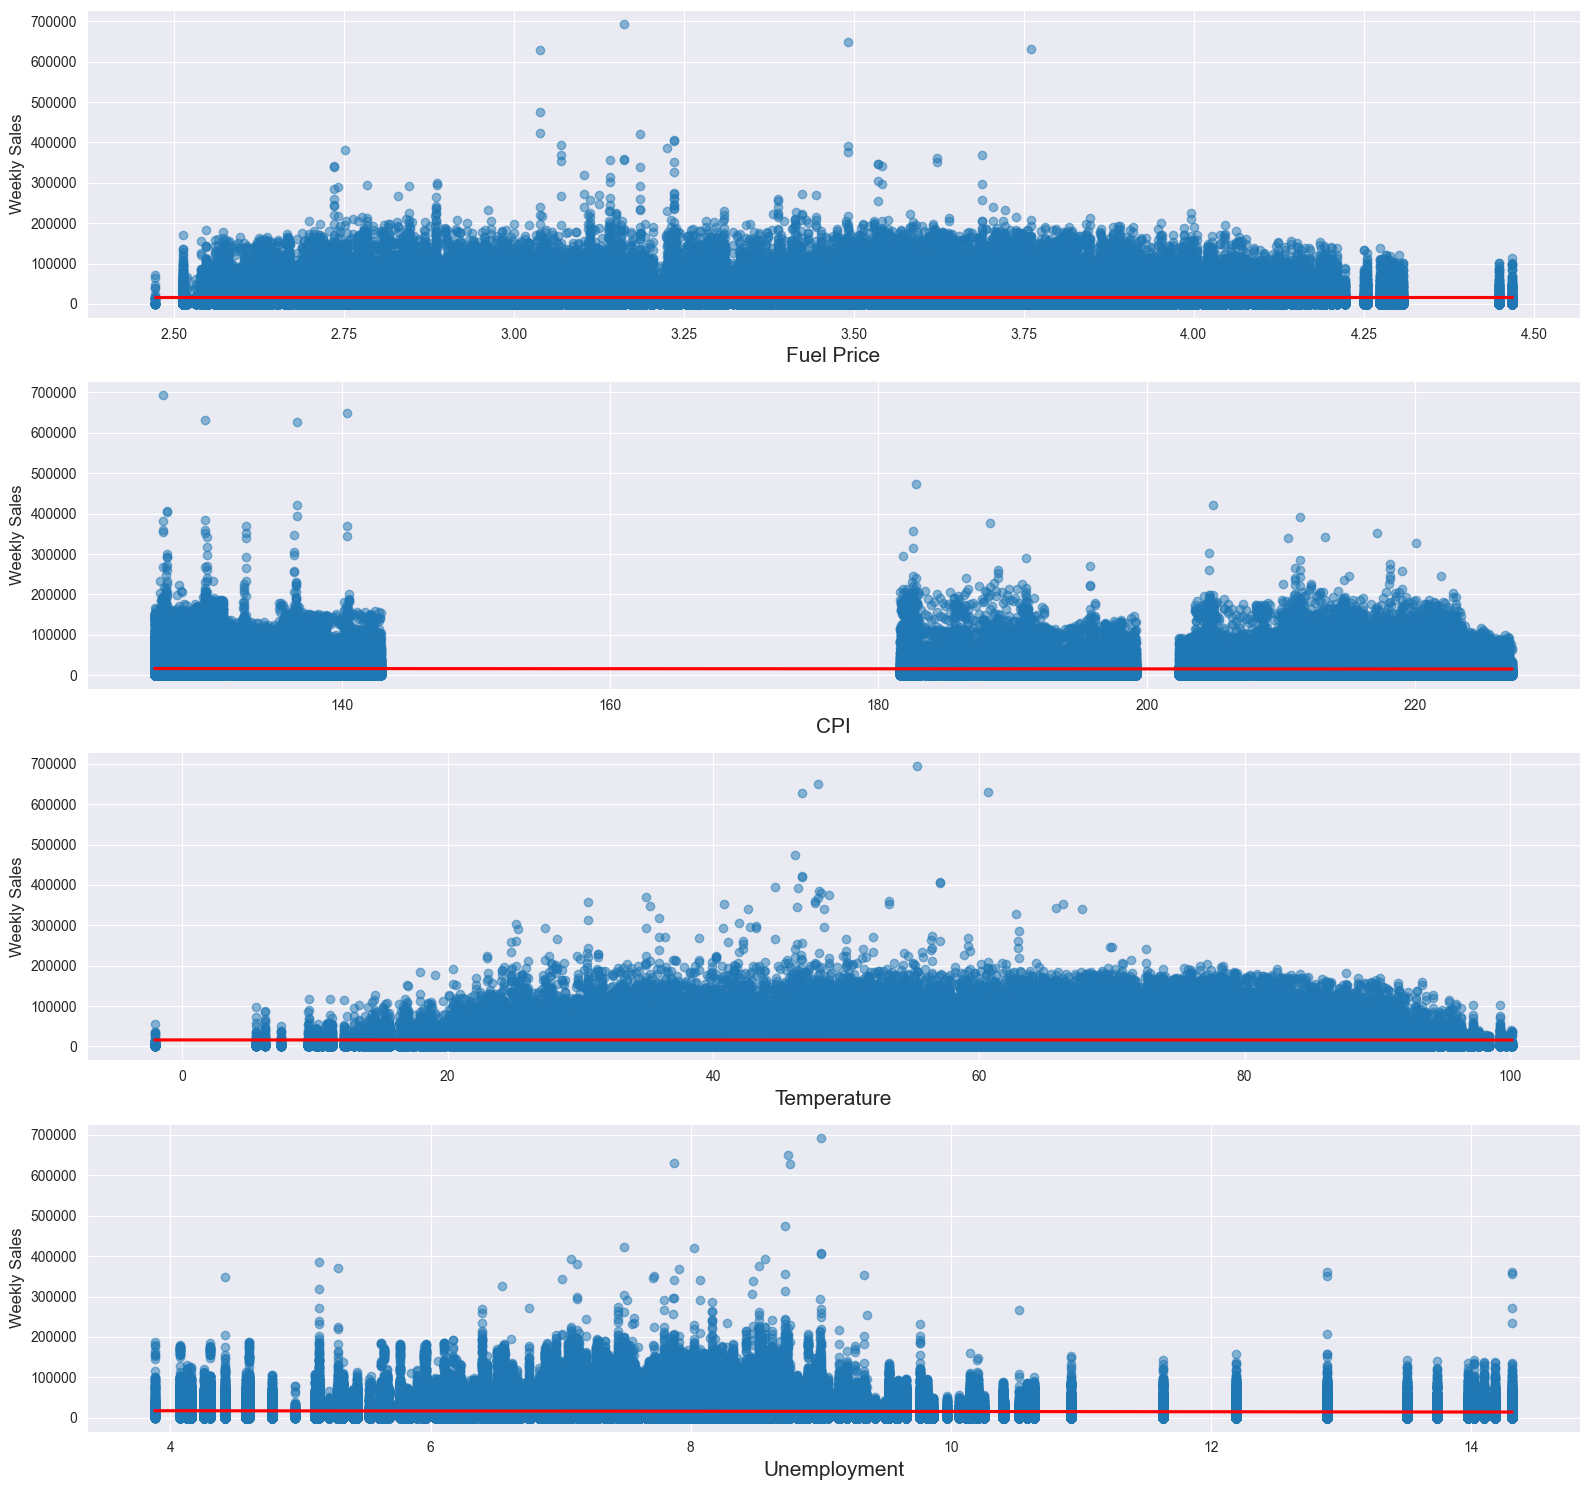

In [19]:
# Set up the figure
plt.figure(figsize=(16, 15))

# Scatter plot with regression for Fuel Price
plt.subplot(4, 1, 1)
sns.regplot(x='Fuel_Price', y='Weekly_Sales', data=df, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
# plt.title('Influence of Fuel Price on Weekly Sales', fontsize=14)
plt.xlabel('Fuel Price', fontsize=15)
plt.ylabel('Weekly Sales', fontsize=12)

# Scatter plot with regression for CPI
plt.subplot(4, 1, 2)
sns.regplot(x='CPI', y='Weekly_Sales', data=df, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
# plt.title('Influence of CPI on Weekly Sales', fontsize=14)
plt.xlabel('CPI', fontsize=15)
plt.ylabel('Weekly Sales', fontsize=12)

# Scatter plot with regression for Temperature
plt.subplot(4, 1, 3)
sns.regplot(x='Temperature', y='Weekly_Sales', data=df, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
# plt.title('Influence of Temperature on Weekly Sales', fontsize=14)
plt.xlabel('Temperature', fontsize=15)
plt.ylabel('Weekly Sales', fontsize=12)

# Scatter plot with regression for Unemployment
plt.subplot(4, 1, 4)
sns.regplot(x='Unemployment', y='Weekly_Sales', data=df, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
# plt.title('Influence of Unemployment on Weekly Sales', fontsize=14)
plt.xlabel('Unemployment', fontsize=15)
plt.ylabel('Weekly Sales', fontsize=12)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### 6. Correlation Analysis

In [22]:
# Move 'Weekly_Sales' to the beginning

df = df.drop(columns=['Store']) # Dropping "Store"(Ordinal data)  

columns = ['Weekly_Sales'] + [col for col in df.columns if col != 'Weekly_Sales']
df = df[columns]

# Encode categorical variables
df_encoded = pd.get_dummies(df)  # Use one-hot encoding and drop the first level

# Compute the correlation matrix
correlation_matrix = df_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)

# Add title
# plt.title('Correlation Matrix', fontsize=16)

plt.tight_layout()
plt.show()


KeyError: "['Store'] not found in axis"

### 7. Outliers in the dataset

In [ ]:
numerical_cols = df.select_dtypes(include='number').columns

# Outlier detection using IQR method 
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_cols, 1):
    Q1 = df[col].quantile(0.25) 
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lb = Q1 - 2 * IQR
    ub = Q3 + 2 * IQR

    #Number of Outliers in each column
    outliers = df[(df[col] < lb) | (df[col] > ub)]
    print(f"Column: {col}, Outliers Detected: {len(outliers)}")

    #Boxplot of the outliers
    plt.subplot(4, 4, i)
    sns.boxplot(y=df[col], color="black")
    plt.axhline(lb, color='red', linestyle='--', label='Lower Bound')
    plt.axhline(ub, color='green', linestyle='--', label='Upper Bound')
    plt.title(f'{col} (Outliers: {len(outliers)})')
    # plt.legend()

plt.tight_layout()
plt.show()


### Mutual Information Analysis

In [ ]:
# Load ML ready dataset
df = pd.read_csv('data/preprocessed/main_ML_ready.csv')

# Select features and target
X = df.drop(columns=['Weekly_Sales'])  # Features
y = df['Weekly_Sales']  # Target

X_encoded = pd.get_dummies(X, drop_first=True)

# Compute mutual information scores
mi_scores = mutual_info_regression(X_encoded, y)

# Create a DataFrame for better visualization
mi_scores_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Mutual Information': mi_scores
}).sort_values(by='Mutual Information', ascending=False)

# Plot the results
plt.figure(figsize=(12, 6))
plt.barh(mi_scores_df['Feature'], mi_scores_df['Mutual Information'], color='skyblue')
plt.title('Mutual Information Scores for Features', fontsize=16)
plt.xlabel('Mutual Information', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.gca().invert_yaxis()  # Highest score at the top
plt.tight_layout()
plt.show()